In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from OutilsP3 import *

from mpl_toolkits.mplot3d import Axes3D

# SciKit Learn
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from mlxtend.plotting import plot_pca_correlation_graph

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import tukeyhsd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
initializePandas()

##### L'objectif de l'application est de nous donner une note de score santé basé sur les valeurs suivantes : 
##### On entre un produit et l'application nous donne un nutri-score
##### Si le produit est pas reneigné on peut rentrer ces igredients afin d'avoir un nutriscore

- taux de graisse, graisse saturée (-)
- taux de glucides, et sucres (-)
- le nombre d'additifs (-)
- présence d'huile de palme (-)
- taux en sel (-)
- taux de protéines (+)
- taux de fibres (+)
- le nutriscore (+)

In [3]:
data = pd.read_csv("openfoodfacts.csv", delimiter = "\t", low_memory=False)
print(data.shape)
data.head(3)

(320772, 162)


,code,url,creator,created_t,created_datetime,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfa...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,...,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfa...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,...,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfa...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,...,NaN,0.0,0.0,NaN,NaN


# <font color='red'>I - Filtrage des données</font>

Il y a 39608589 valeurs manquantes sur 51965064 valeurs totales.
Le taux de remplissage est de : 23.77 %
Dimension du dataframe : (320772, 162)


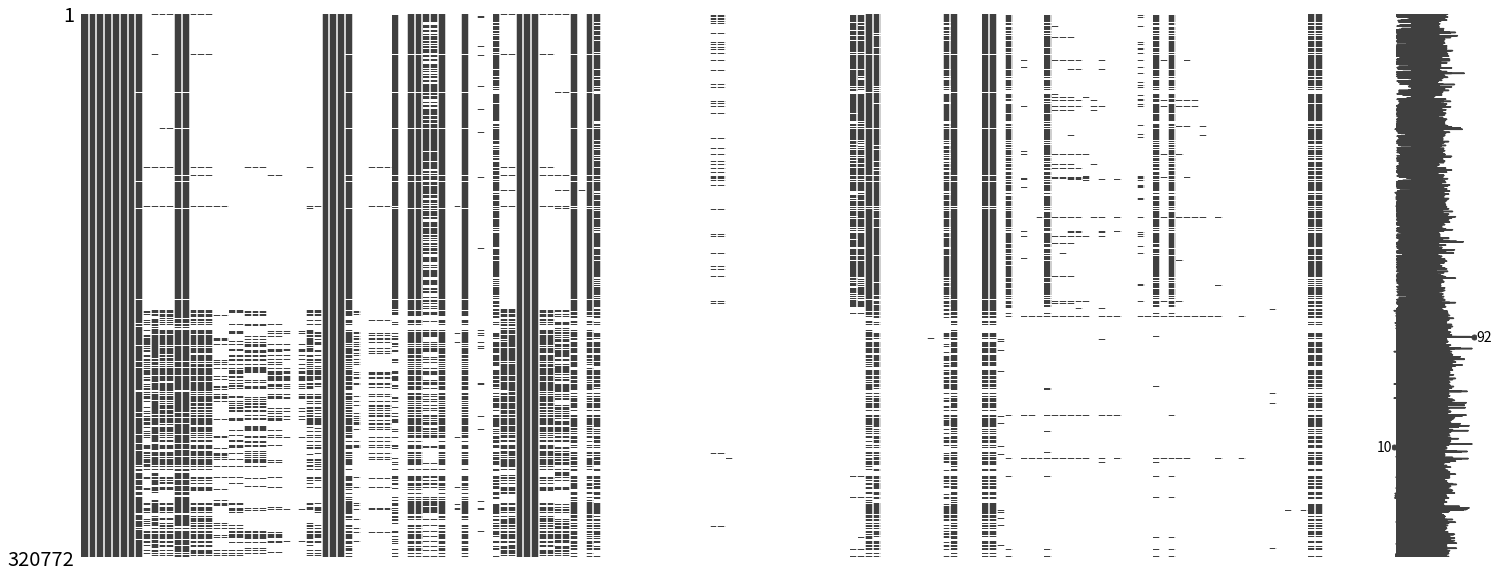

In [4]:
missingValuesInfos(data)

In [5]:
# Etant donné que l'appel à projet a été lancé par "Santé publique France", on s'attardera uniquement sur les produits qui sont vendus en france

data["countries_fr"] = data["countries_fr"].str.lower()
fraMask = data["countries_fr"].str.contains("france")
fraMask.fillna(True, inplace = True)
print(data[fraMask].shape)
data = data[fraMask]

(98720, 162)


Il y a 12138669 valeurs manquantes sur 15992640 valeurs totales.
Le taux de remplissage est de : 24.09 %
Dimension du dataframe : (98720, 162)


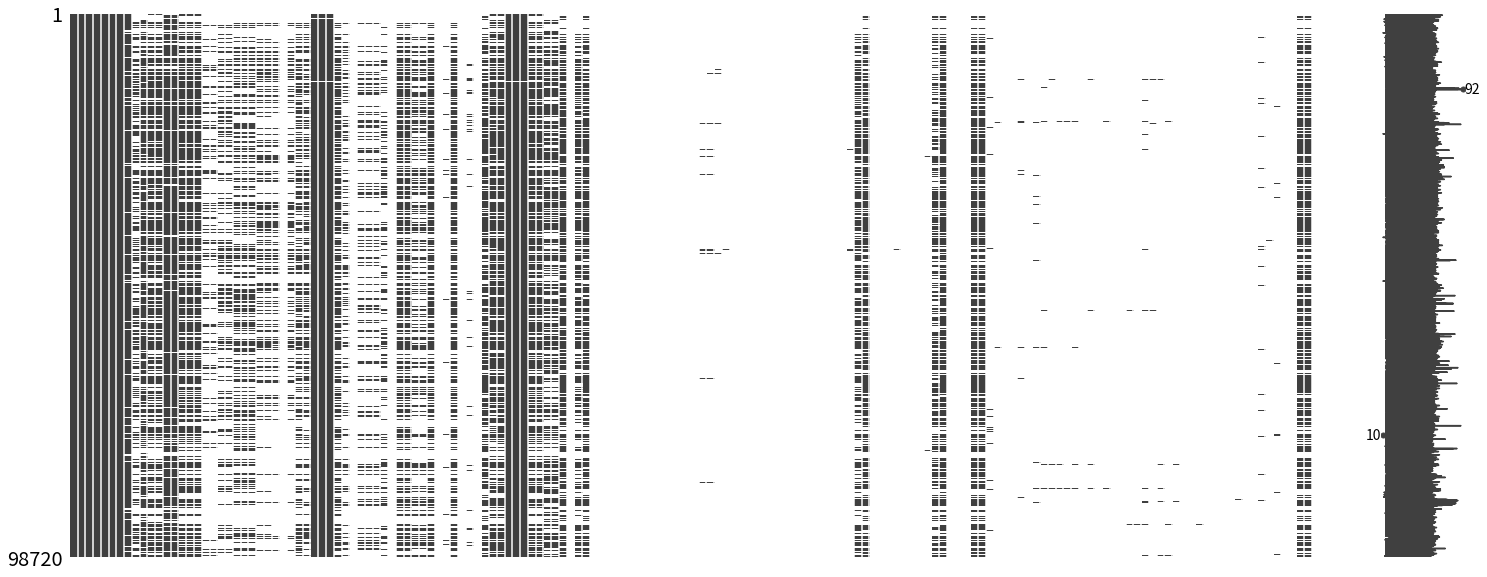

In [6]:
missingValuesInfos(data)

Colonnes suprimées : 
['cities', 'allergens_fr', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'melissic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'elaidic-acid_100g', 'gondoic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g']

Shape : 
(98720, 136)
Il y a 9571949 valeurs manquantes sur 13425920 valeurs totales.
Le taux de remplissage est de : 28.7 %
Dimension du dataframe : (98720, 136)


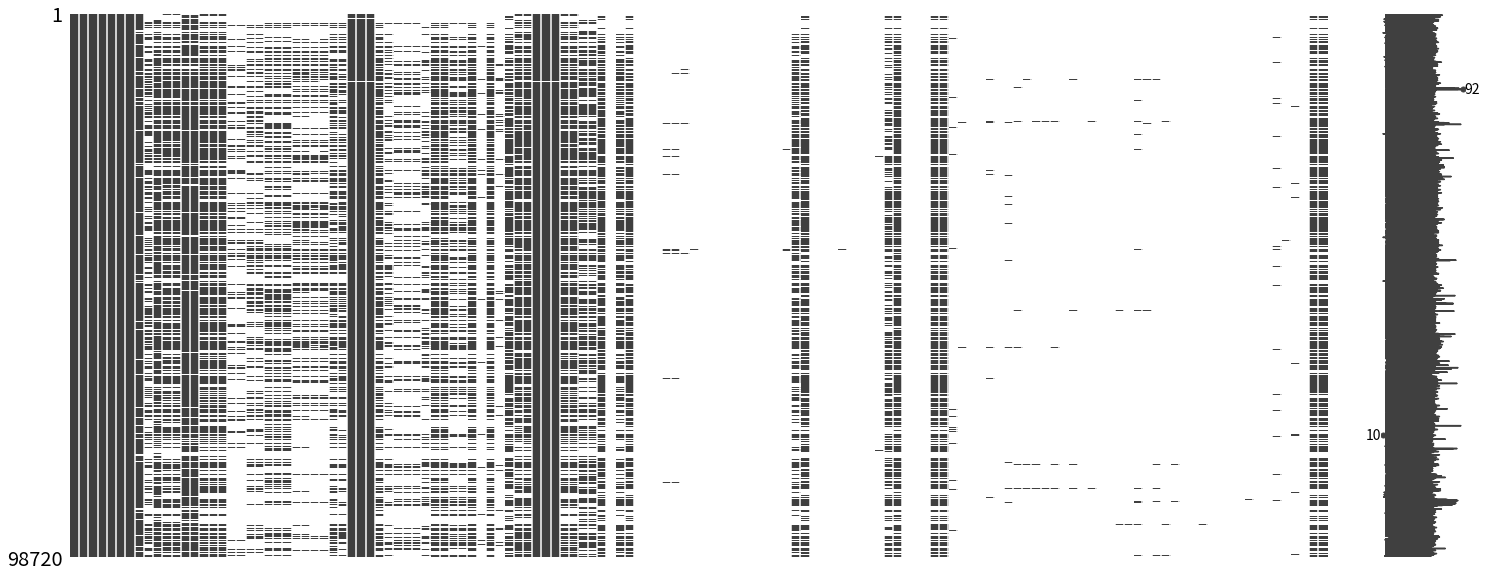

In [7]:
#Supression des colonnes vides
deletedColumns = []
for e in data.columns :
    if data[e].isna().sum() == len(data):
        data.pop(e)
        deletedColumns.append(e)
print("Colonnes suprimées : ")
print(deletedColumns)
print("\nShape : ")
print(data.shape)

missingValuesInfos(data)

In [8]:
# On selectionne les colonnes qui seront utiles à notre application comme décrit au début.
appData = data.loc[:,['code','additives_n','ingredients_that_may_be_from_palm_oil_n',
                      'fat_100g','saturated-fat_100g','energy_100g',
                      'carbohydrates_100g','sugars_100g',
                      'fiber_100g', 'proteins_100g','salt_100g','nutrition-score-fr_100g','pnns_groups_2','labels_fr']].copy()
appData.reset_index(inplace = True, drop = True)

In [9]:
compareColumns(data, ["labels","labels_tags","labels_fr"])

il y a 2 valeurs dans labels qui sont manquantes dans labels_tags.
il y a 2 valeurs dans labels qui sont manquantes dans labels_fr.
il y a 41 valeurs dans labels_tags qui sont manquantes dans labels.
il y a 0 valeurs dans labels_tags qui sont manquantes dans labels_fr.
il y a 41 valeurs dans labels_fr qui sont manquantes dans labels.
il y a 0 valeurs dans labels_fr qui sont manquantes dans labels_tags.


Il y a 554959 valeurs manquantes sur 1382080 valeurs totales.
Le taux de remplissage est de : 59.84 %
Dimension du dataframe : (98720, 14)


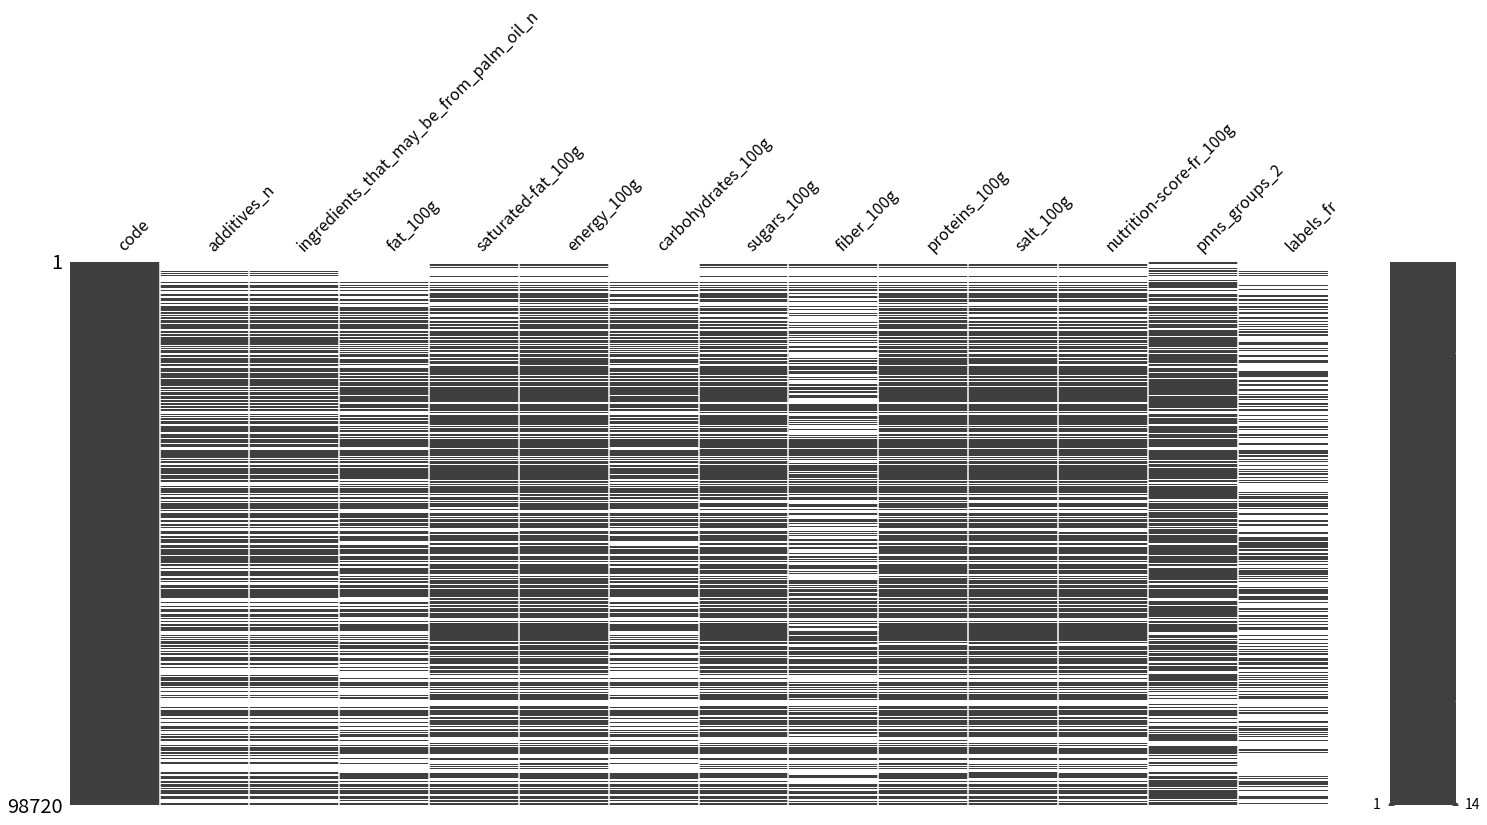

In [10]:
missingValuesInfos(appData)

# <font color='red'>II - Nettoyage</font>
## <font color='green'>II/1 - Valeurs abberantes</font>

In [11]:
# Saturated-fat_100g > fat_100g
appData.loc[appData["saturated-fat_100g"] > appData["fat_100g"],"saturated-fat_100g"] = np.nan

# sugars_100g > carbohydrates_100g
appData.loc[appData["sugars_100g"] > appData["carbohydrates_100g"],"sugars_100g"] = np.nan

In [12]:
# 1g gras = 9 kCal = 9 * 4.18 kJ
# 100g gras = 900 kCal = 900 * 4.18 kJ = 3762 kJ -> Valeur maximum pour energy_100g
appData.loc[appData["energy_100g"] > 3762,"energy_100g"] = np.nan

In [13]:
# *_100g > 100g
for e in ['fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g', 'proteins_100g','salt_100g'] :
    appData.loc[appData[e]>100,e] = np.nan

In [14]:
# *_100g < 0g
for e in ['additives_n','ingredients_that_may_be_from_palm_oil_n','fat_100g','nutrition-score-fr_100g',
          'saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g', 'proteins_100g','salt_100g'] :
    appData.loc[appData[e]<0,e] = np.nan

0.19% de valeurs abberantes

## <font color='green'>II/2 - Valeurs manquantes</font>

In [15]:
# Selection des individus avec plus d'infos que juste le code
mask = appData.notna().sum(axis = 1) >= 2
appData = appData.loc[mask]
appData.shape

(81383, 14)

Il y a 340302 valeurs manquantes sur 1139362 valeurs totales.
Le taux de remplissage est de : 70.13 %
Dimension du dataframe : (81383, 14)


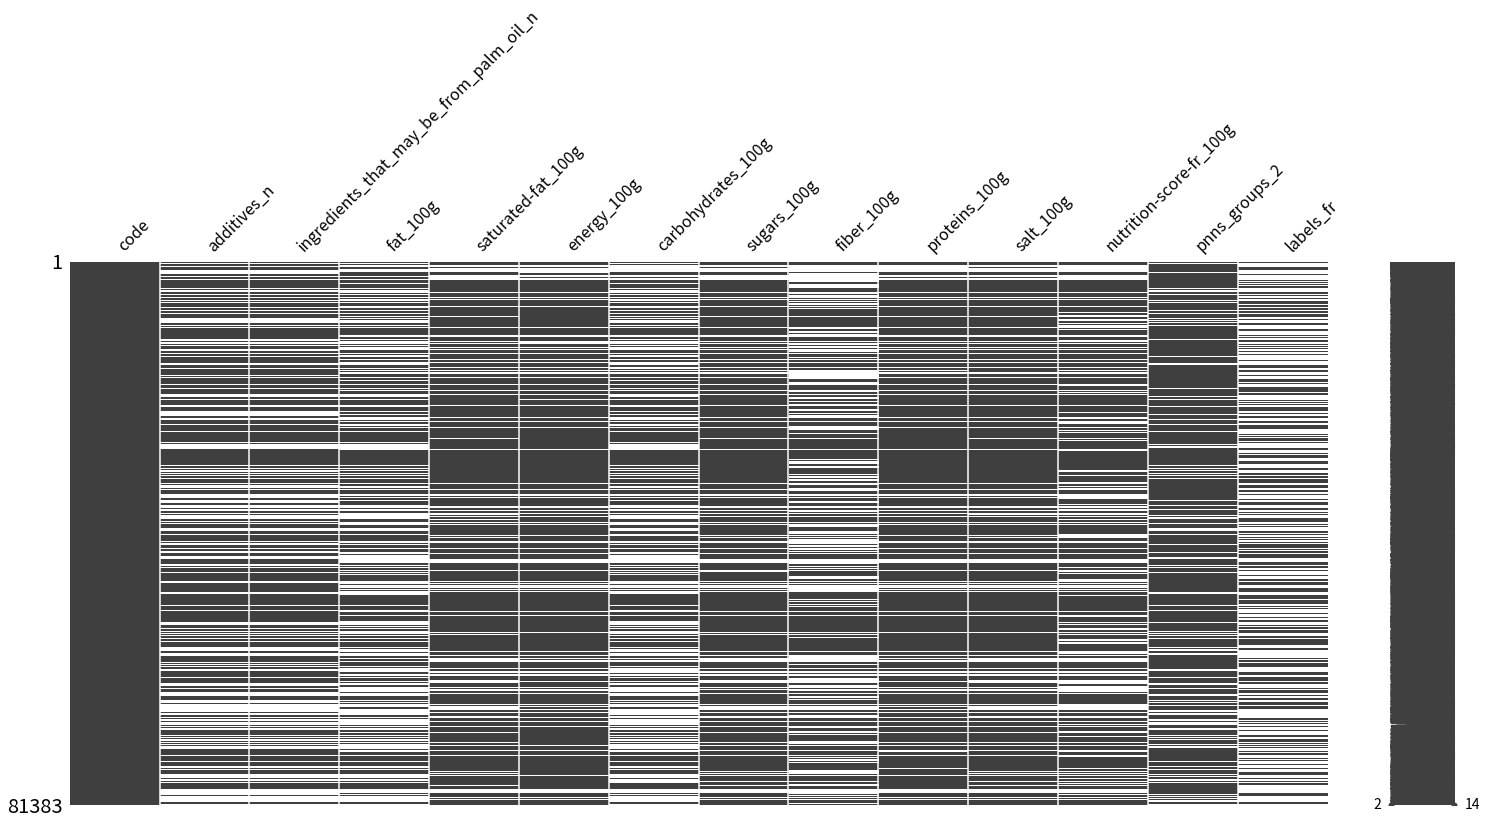

In [16]:
missingValuesInfos(appData)

In [17]:
# On élimine les individus qui ont un total d'ingredients <= 0
mask = appData.loc[:,["fat_100g","carbohydrates_100g","fiber_100g","proteins_100g","salt_100g"]].sum(axis = 1) > 0
appData = appData[mask]
appData.shape

(64375, 14)

Il y a 166060 valeurs manquantes sur 901250 valeurs totales.
Le taux de remplissage est de : 81.57 %
Dimension du dataframe : (64375, 14)


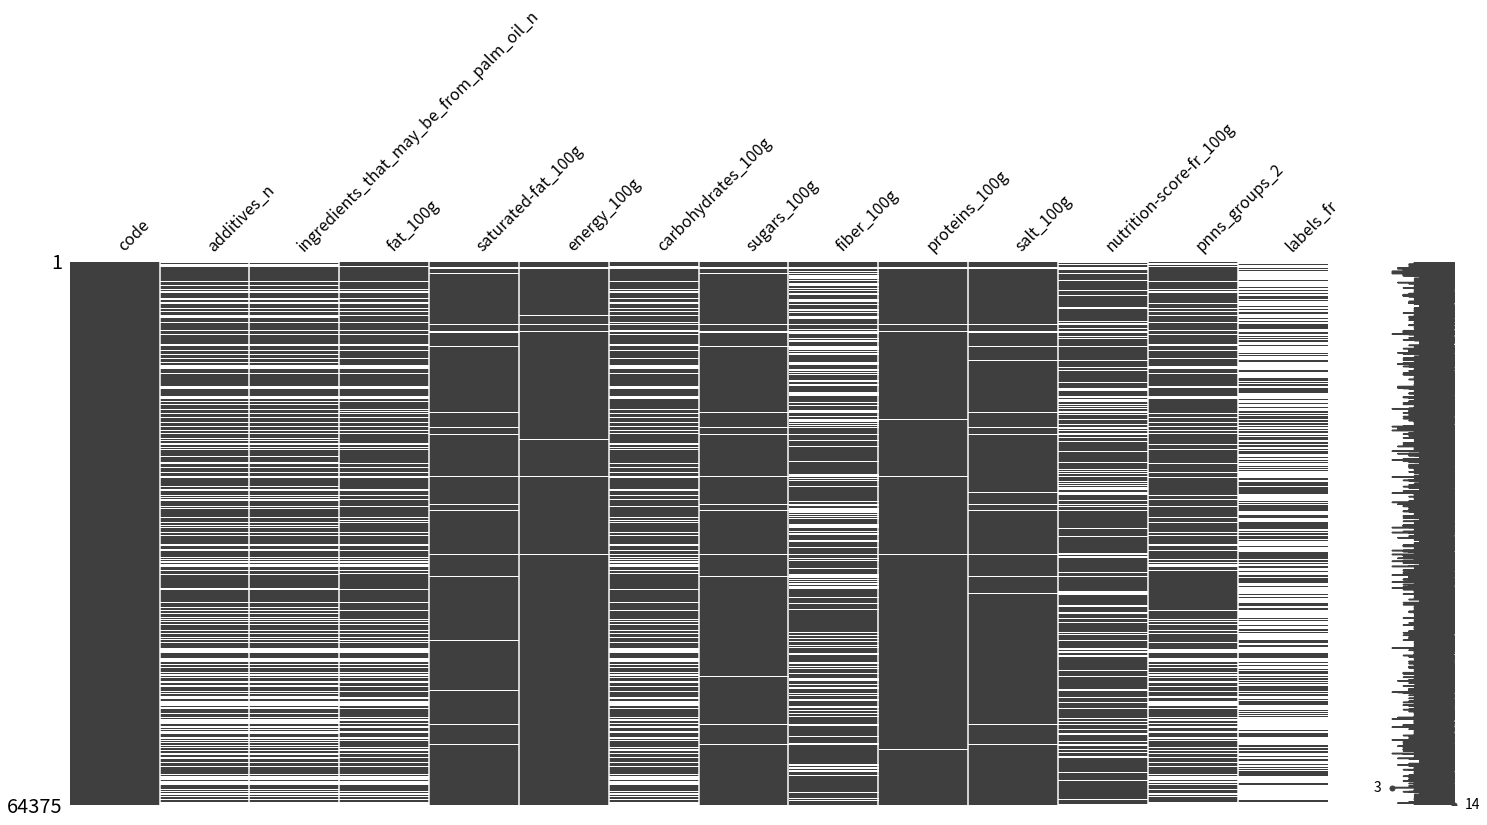

In [18]:
missingValuesInfos(appData)

In [19]:
# On supprime les ligne sans code, et on formate les codes en int
appData.dropna(axis = 0, subset = "code", inplace = True)
for i in appData.index :
    appData.loc[i,"code"] = int(appData.loc[i,"code"])
appData.shape

(64375, 14)

In [20]:
appData.columns

Index(['code', 'additives_n', 'ingredients_that_may_be_from_palm_oil_n',
       'fat_100g', 'saturated-fat_100g', 'energy_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'nutrition-score-fr_100g', 'pnns_groups_2', 'labels_fr'],
      dtype='object')

## <font color='green'>II/3 - Correction des valeurs</font>

Ceux dont la liste d'ingredients additionnée dépasse 100g seront proportionellement ramené pour un total de 100g
<br>
Etant donnée qu'on a supprimé des ingredients lors de la selection des données on ne normalisera pas dans l'autre sens.

In [21]:
# Sommes des ingredients :

total_100g = appData.loc[:,["fat_100g","carbohydrates_100g","fiber_100g","proteins_100g","salt_100g"]].sum(axis = 1)
total_100g.loc[(total_100g<100)] = 100
print((total_100g>100).sum())
print(total_100g.shape)

471
(64375,)


In [22]:
print("Avant la normalisation à 100g :")
print(appData.loc[:,["fat_100g","carbohydrates_100g","fiber_100g","proteins_100g","salt_100g"]][total_100g>100])

for e in ["fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","fiber_100g","proteins_100g","salt_100g"] :
    appData[e] = appData[e] * 100 / total_100g

# Arrondi à 10^-2
appData.loc[:,["fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","fiber_100g","proteins_100g","salt_100g"]] = appData.loc[:,["fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","fiber_100g","proteins_100g","salt_100g"]].round(decimals = 2)

      
print("\nAprès la normalisation à 100g :")
print(appData.loc[:,["fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","fiber_100g","proteins_100g","salt_100g"]][total_100g>100])

Avant la normalisation à 100g :
       fat_100g  carbohydrates_100g  fiber_100g  proteins_100g  salt_100g
218        32.4                57.8        5.40            5.1     0.8001
219        25.3                66.5        5.80            3.8     0.8000
220        25.9                65.3        5.10            4.3     0.9000
221        30.4                60.1        4.20            4.9     0.7000
224        14.5                74.2        6.50            6.5     0.7366
...         ...                 ...         ...            ...        ...
98042      21.3                61.7        2.45           12.6     2.2225
98043      21.3                61.7        2.45           12.6     2.2225
98081      44.5                42.5        9.50            9.5     0.0127
98351      50.0                39.0        9.00            7.1     0.5000
98359      39.0                54.0        4.00            6.0     1.3462

[471 rows x 5 columns]

Après la normalisation à 100g :
       fat_100g  satura

## <font color='green'>II/4 - Gestion des doublons</font>

In [23]:
appData.duplicated(keep = False).sum()

0

Au vu du nombre de doublons on va simplement les supprimer, on conservera uniquement le premier

In [24]:
appData.drop_duplicates(subset = 'code', keep = 'first', inplace = True)

In [25]:
appData.reset_index(drop = True, inplace = True)

# <font color='red'>III - Valeurs manquantes et Imputations</font>

In [26]:
# Gestion de la casse Pnns_Groups_2
appData["pnns_groups_2"] = appData["pnns_groups_2"].str.capitalize()

<AxesSubplot:>

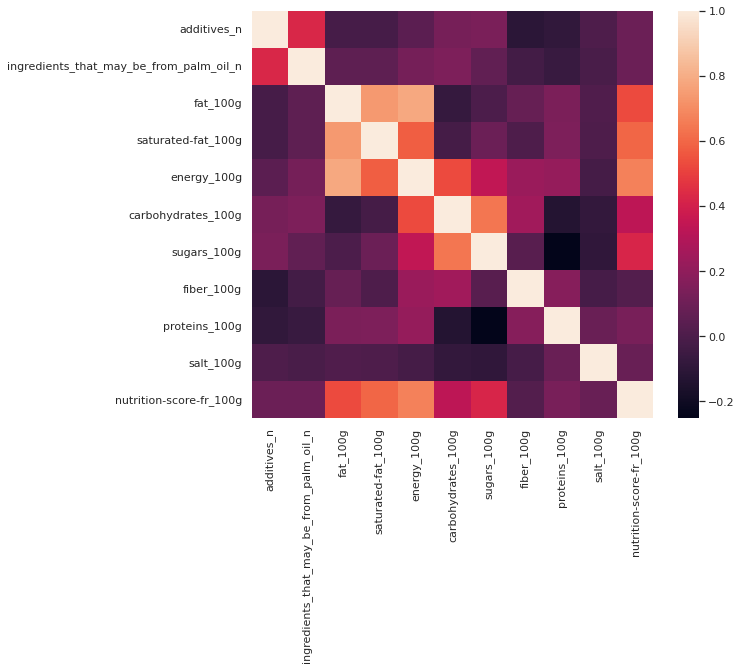

In [27]:
# Etudes des correlations :
sns.set(rc={'figure.figsize':(9,7.5)})
sns.heatmap(appData.corr())

On remarque une corrélation entre les 4 colonnes suivantes :
 - fat_100g
 - saturated-fat_100g
 - energy_100g
 - nutrition-score-fr_100g
<br>
On en remarque une également moins importante entre les 4 colonnes suivantes :
 - carbohydrates_100g
 - sugars_100g
 - energy_100g

<br>
On va donc utiliser un KNN Imputer pour compléter ces deux séries de correlations

Il y a 166054 valeurs manquantes sur 901222 valeurs totales.
Le taux de remplissage est de : 81.57 %
Dimension du dataframe : (64373, 14)


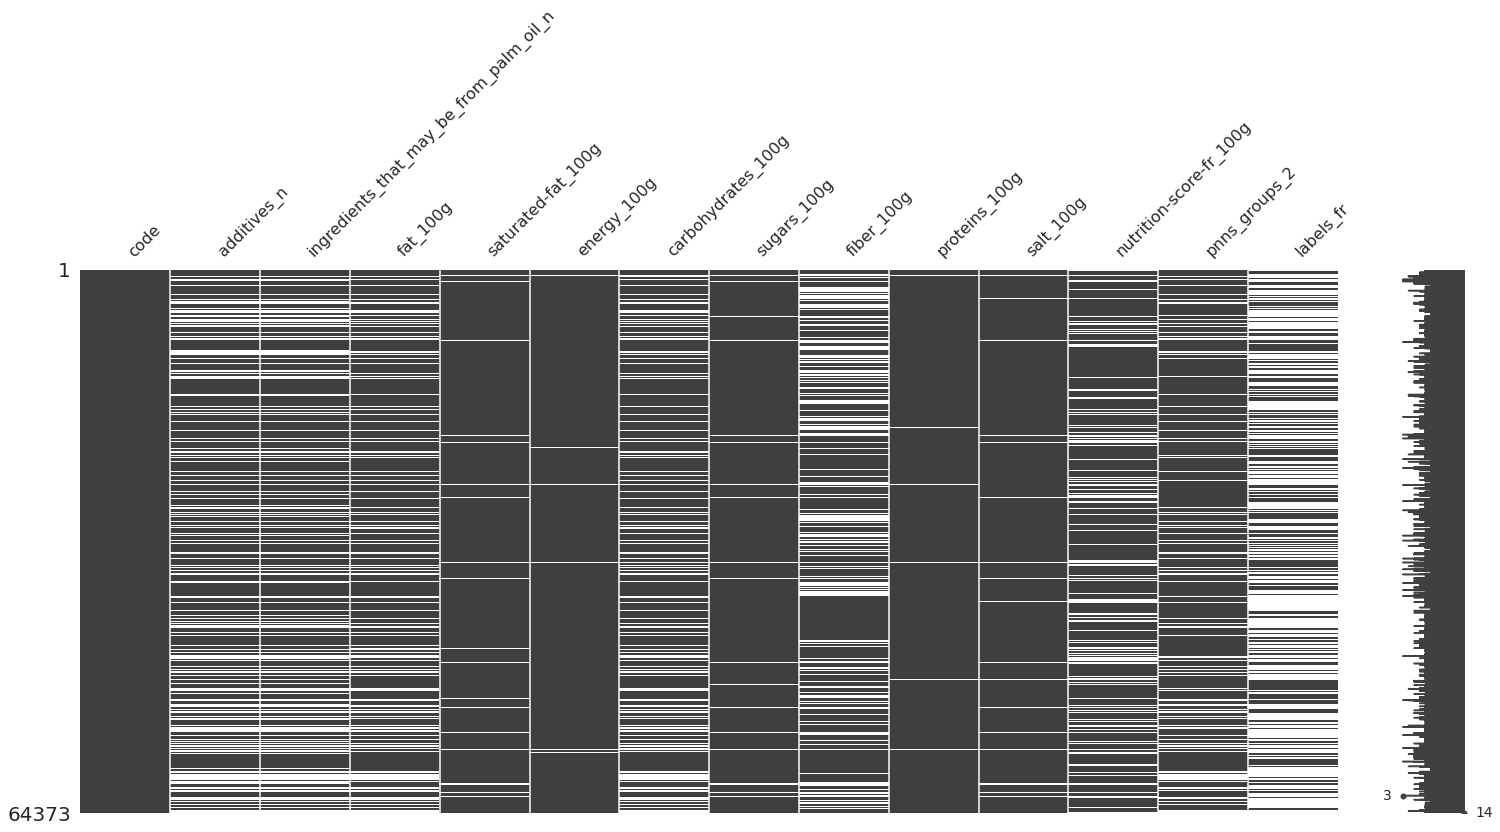

In [28]:
missingValuesInfos(appData)

## <font color='green'>III/1 - Fat & saturated-fat</font>

Après plusieurs essais l'hyperparamètre n_neighbors nous donne le meilleur résultat aux alentours de 130.
<br>
(meilleur résultat = sns.pairplot(appData.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']]) les plus resemblants

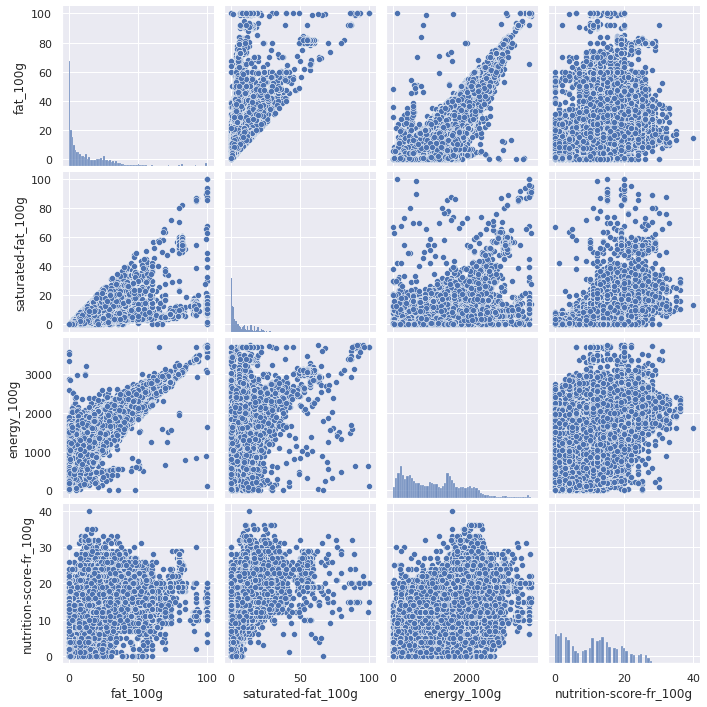

In [29]:
sns.pairplot(appData.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']])

In [30]:
print("Nombre de valeurs imputées :")
print(appData.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']].isna().sum())
print("Nombre de valeurs imputées total :",appData.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']].isna().sum().sum())

Nombre de valeurs imputées :
fat_100g                   16810
saturated-fat_100g          2730
energy_100g                  688
nutrition-score-fr_100g    13942
dtype: int64
Nombre de valeurs imputées total : 34170


In [31]:
imputer = KNNImputer(n_neighbors = 150, missing_values = np.nan)
imputedAppDataFat = imputer.fit_transform(appData.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']])

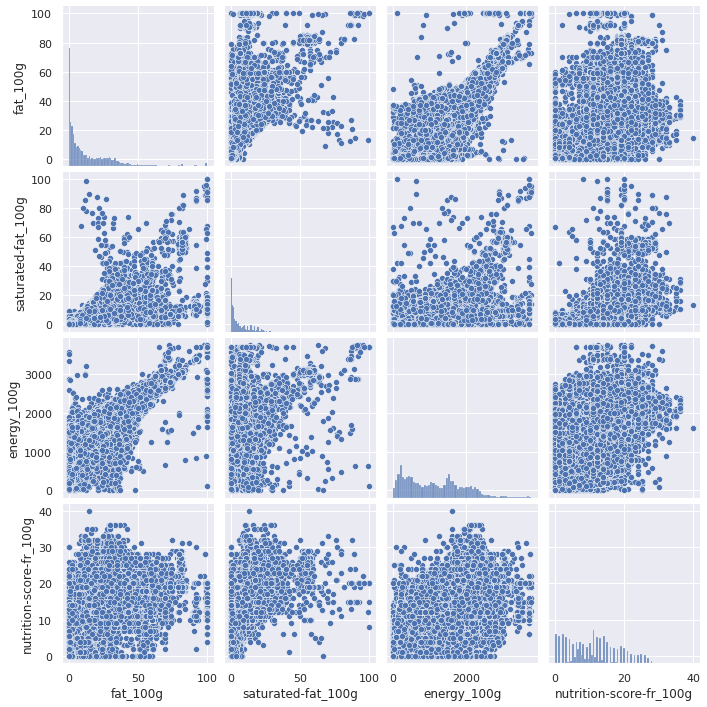

In [32]:
imputedAppDataFat = pd.DataFrame(data=imputedAppDataFat, index = None, columns = ['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g'])
sns.pairplot(imputedAppDataFat.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']])

Au vu du résultat, certaines valeurs aberantes sont ressorties notamment dans saturated-fat_100g
<br>
On va donc les supprimer et les ré-imputer.

In [33]:
imputedAppDataFat.loc[imputedAppDataFat["saturated-fat_100g"] > imputedAppDataFat["fat_100g"],"saturated-fat_100g"] = np.nan

In [34]:
print("Nombre de valeurs imputées :")
print(imputedAppDataFat.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']].isna().sum())
print("Nombre de valeurs imputées total :",imputedAppDataFat.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']].isna().sum().sum())

Nombre de valeurs imputées :
fat_100g                      0
saturated-fat_100g         1003
energy_100g                   0
nutrition-score-fr_100g       0
dtype: int64
Nombre de valeurs imputées total : 1003


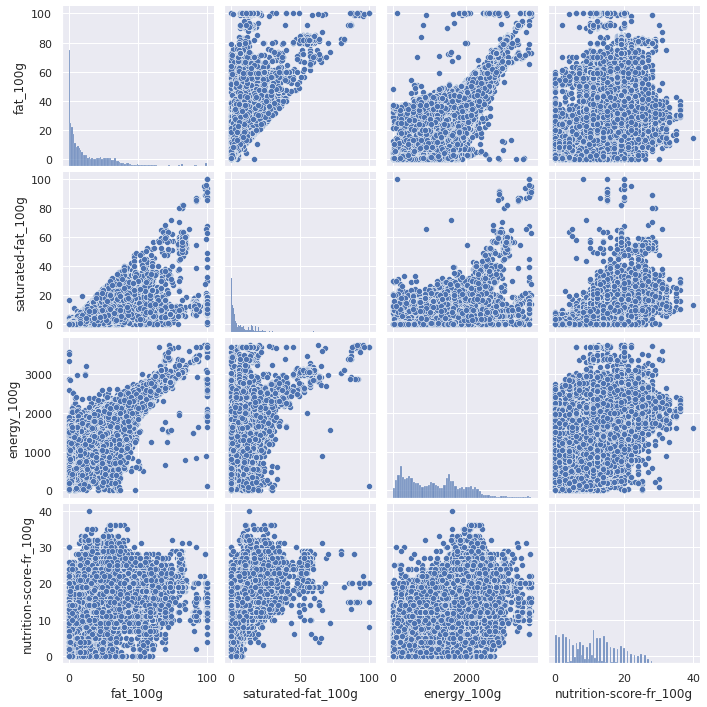

In [35]:
imputedAppDataFat = imputer.fit_transform(imputedAppDataFat.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']])
imputedAppDataFat = pd.DataFrame(data=imputedAppDataFat, index = None, columns = ['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g'])
sns.pairplot(imputedAppDataFat.loc[:,['fat_100g','saturated-fat_100g','energy_100g','nutrition-score-fr_100g']])

In [36]:
imputedAppDataFat.shape

(64373, 4)

## <font color='green'>III/2 - Carbohydrates & sugars</font>

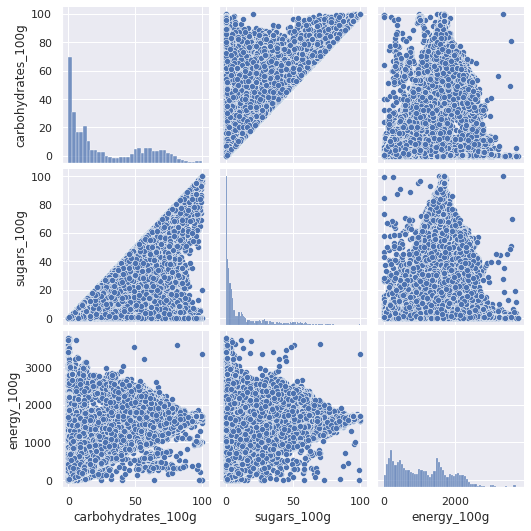

In [37]:
sns.pairplot(appData.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']])

In [38]:
print("Nombre de valeurs imputées :")
print(appData.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']].isna().sum())
print("Nombre de valeurs imputées total :",appData.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']].isna().sum().sum())

Nombre de valeurs imputées :
carbohydrates_100g    17240
sugars_100g            2673
energy_100g             688
dtype: int64
Nombre de valeurs imputées total : 20601


In [39]:
imputer = KNNImputer(n_neighbors = 175, missing_values = np.nan)
imputedAppDataSugars = imputer.fit_transform(appData.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']])

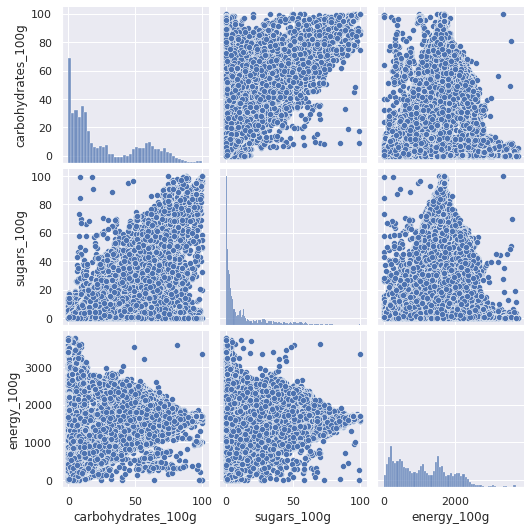

In [40]:
imputedAppDataSugars = pd.DataFrame(data=imputedAppDataSugars, index = None, columns = ['carbohydrates_100g','sugars_100g','energy_100g'])
sns.pairplot(imputedAppDataSugars.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']])

In [41]:
# sugars_100g > carbohydrates_100g
imputedAppDataSugars.loc[imputedAppDataSugars["sugars_100g"] > imputedAppDataSugars["carbohydrates_100g"],"sugars_100g"] = np.nan

In [42]:
print("Nombre de valeurs imputées :")
print(imputedAppDataSugars.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']].isna().sum())
print("Nombre de valeurs imputées total :",imputedAppDataSugars.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']].isna().sum().sum())

Nombre de valeurs imputées :
carbohydrates_100g       0
sugars_100g           2700
energy_100g              0
dtype: int64
Nombre de valeurs imputées total : 2700


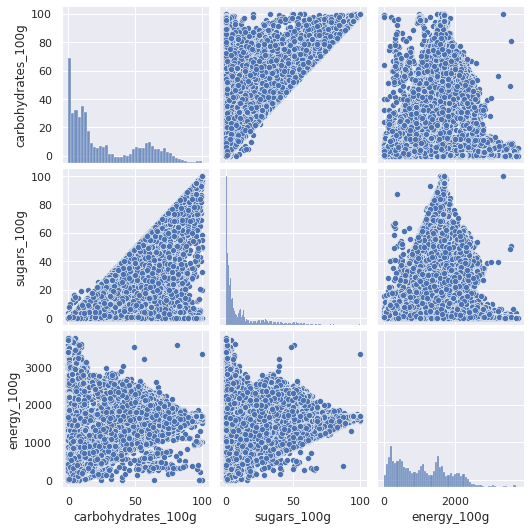

In [43]:
# sugars_100g > carbohydrates_100g
imputedAppDataSugars.loc[imputedAppDataSugars["sugars_100g"] > imputedAppDataSugars["carbohydrates_100g"],"sugars_100g"] = np.nan

imputedAppDataSugars = imputer.fit_transform(imputedAppDataSugars.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']])
imputedAppDataSugars = pd.DataFrame(data=imputedAppDataSugars, index = None, columns = ['carbohydrates_100g','sugars_100g','energy_100g'])
sns.pairplot(imputedAppDataSugars.loc[:,['carbohydrates_100g','sugars_100g','energy_100g']])


In [44]:
imputedAppDataSugars.shape

(64373, 3)

## <font color='green'>III/3 - energy & Imputation</font>

In [45]:
print("imputedAppDataFat.shape :", imputedAppDataFat.shape)
print("imputedAppDataFat.Nan : ",imputedAppDataFat.isna().sum().sum())
print("imputedAppDataSugars.shape :", imputedAppDataSugars.shape)
print("imputedAppDataSugars.Nan : ",imputedAppDataSugars.isna().sum().sum())
print("appData.shape :", appData.shape)

imputedAppDataFat.shape : (64373, 4)
imputedAppDataFat.Nan :  0
imputedAppDataSugars.shape : (64373, 3)
imputedAppDataSugars.Nan :  0
appData.shape : (64373, 14)


In [46]:
appData["fat_100g"] = imputedAppDataFat["fat_100g"]        
appData["saturated-fat_100g"] = imputedAppDataFat["saturated-fat_100g"]
appData["carbohydrates_100g"] = imputedAppDataSugars["carbohydrates_100g"]
appData["sugars_100g"] = imputedAppDataSugars["sugars_100g"]
appData["nutrition-score-fr_100g"] = imputedAppDataFat["nutrition-score-fr_100g"]
appData["energy_100g"] = ( imputedAppDataFat["energy_100g"] + imputedAppDataSugars["energy_100g"] ) / 2

Il y a 111971 valeurs manquantes sur 901222 valeurs totales.
Le taux de remplissage est de : 87.57 %
Dimension du dataframe : (64373, 14)


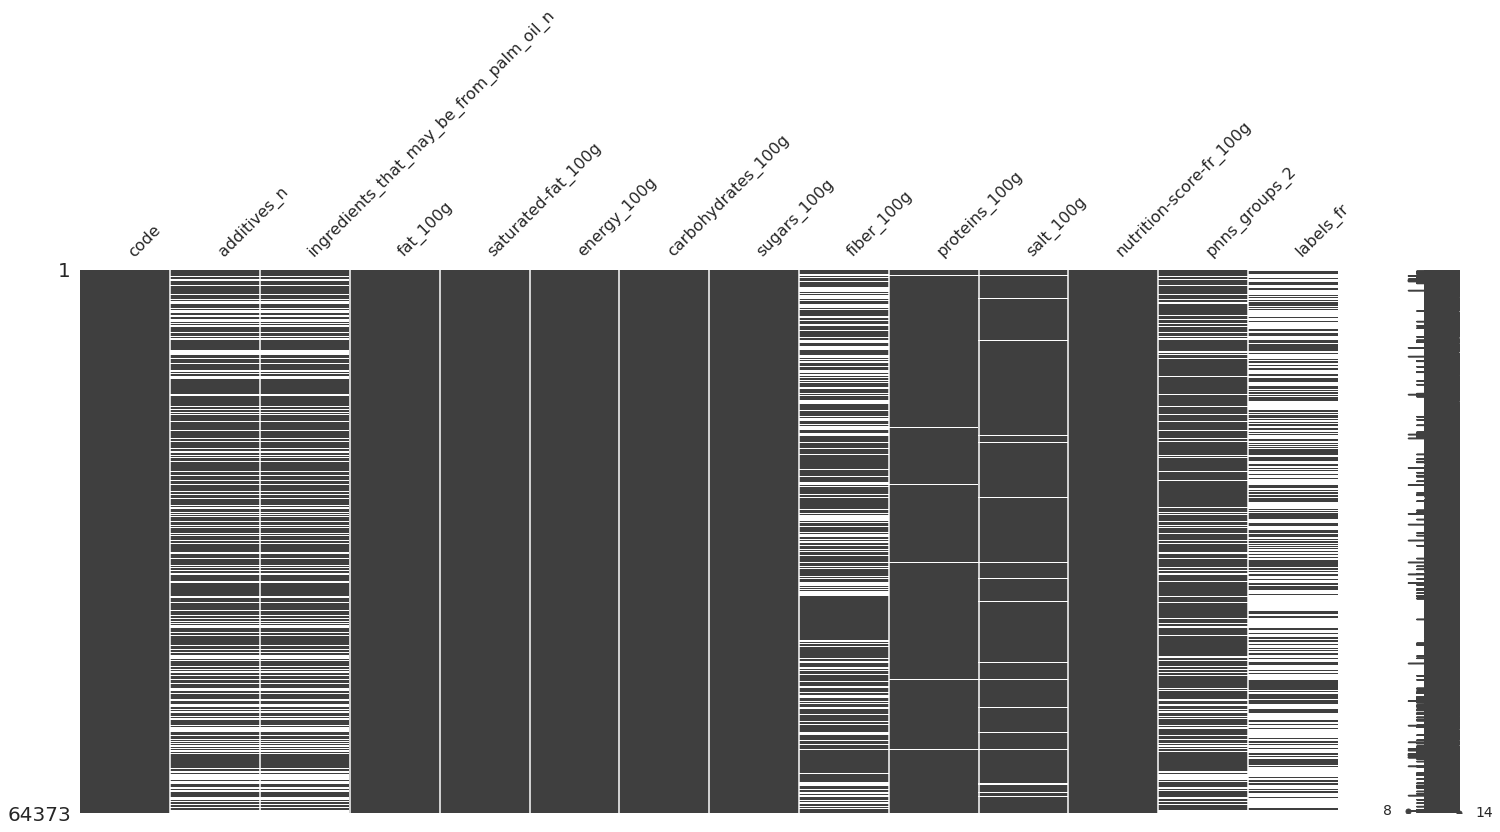

In [47]:
missingValuesInfos(appData)

## <font color='green'>III/4 - Proteins & salt</font>

PROTEINS

In [48]:
print("Valeurs nulles dans proteins_100g :",appData["proteins_100g"].isna().sum())

Valeurs nulles dans proteins_100g : 712


In [49]:
appData["proteins_100g"].describe()

count    63661.000000
mean         7.831349
std          7.826913
min          0.000000
25%          2.000000
50%          6.000000
75%         11.000000
max         97.060000
Name: proteins_100g, dtype: float64

Pour les proteines, on fera une simple imputation par la moyenne et par pnns_groups_2

In [50]:
for e in appData["pnns_groups_2"].unique() :
    appData.loc[((appData["pnns_groups_2"] == e) * (appData["proteins_100g"].isna())),"proteins_100g"] = appData[appData["pnns_groups_2"] == e]["proteins_100g"].mean()

SALT

In [51]:
print("Valeurs nulles dans salt_100g :",appData["salt_100g"].isna().sum())
print("Mediane du taux de sel :",appData["salt_100g"].median())

Valeurs nulles dans salt_100g : 2457
Mediane du taux de sel : 0.58


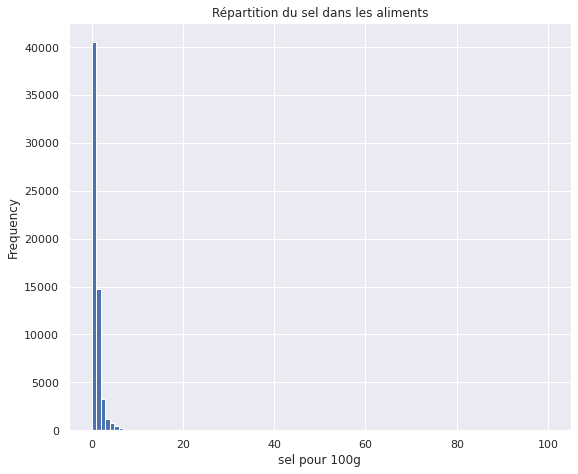

In [52]:
appData["salt_100g"].plot.hist(bins = 100)
plt.title("Répartition du sel dans les aliments")
plt.xlabel("sel pour 100g")
plt.show()

Au vu de la distribution du sel dans les aliments, on imputera les 2457 valeurs manquantes par la mediane, par pnns_groups_2

In [53]:
for e in appData["pnns_groups_2"].unique() :
    appData.loc[((appData["pnns_groups_2"] == e) * (appData["salt_100g"].isna())),"salt_100g"] = appData[appData["pnns_groups_2"] == e]["salt_100g"].median()

## <font color='green'>III/5 - Palm Oil ingredients</font>

Mediane du nombre palm_oil : 0.0
Moyenne du nombre palm_oil : 0.16348378317078702
Nb de valeurs manquantes dans palm_oil : 20283


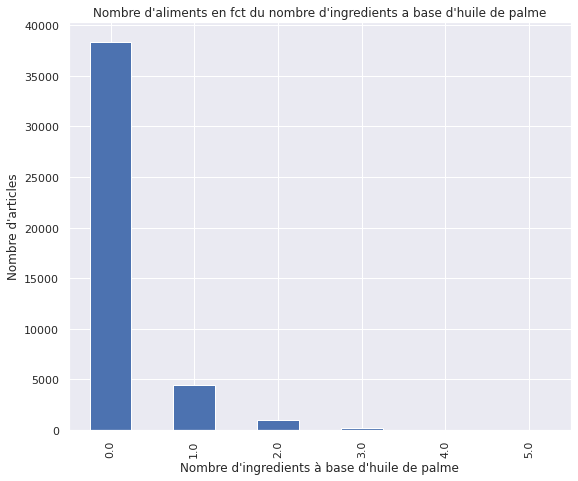

In [54]:
print("Mediane du nombre palm_oil :", appData.loc[:,'ingredients_that_may_be_from_palm_oil_n'].median())
print("Moyenne du nombre palm_oil :", appData.loc[:,'ingredients_that_may_be_from_palm_oil_n'].mean())
print("Nb de valeurs manquantes dans palm_oil :", appData.loc[:,'ingredients_that_may_be_from_palm_oil_n'].isna().sum())

# Graphique barplot
appData['ingredients_that_may_be_from_palm_oil_n'].value_counts().plot.bar()
plt.title("Nombre d'aliments en fct du nombre d'ingredients a base d'huile de palme")
plt.xlabel("Nombre d'ingredients à base d'huile de palme")
plt.ylabel("Nombre d'articles")
plt.show()

In [55]:
appData['ingredients_that_may_be_from_palm_oil_n'].isna().sum()

20283

Au vu de la distribution de cette variable, on imputera ici simplement les valeurs manquantes par 0.

In [56]:
appData.loc[appData['ingredients_that_may_be_from_palm_oil_n'].isna(),'ingredients_that_may_be_from_palm_oil_n'] = 0

## <font color='green'>III/6 - Fibers</font>

Il y a 33030 valeurs manquantes sur 193119 valeurs totales.
Le taux de remplissage est de : 82.89 %
Dimension du dataframe : (64373, 3)


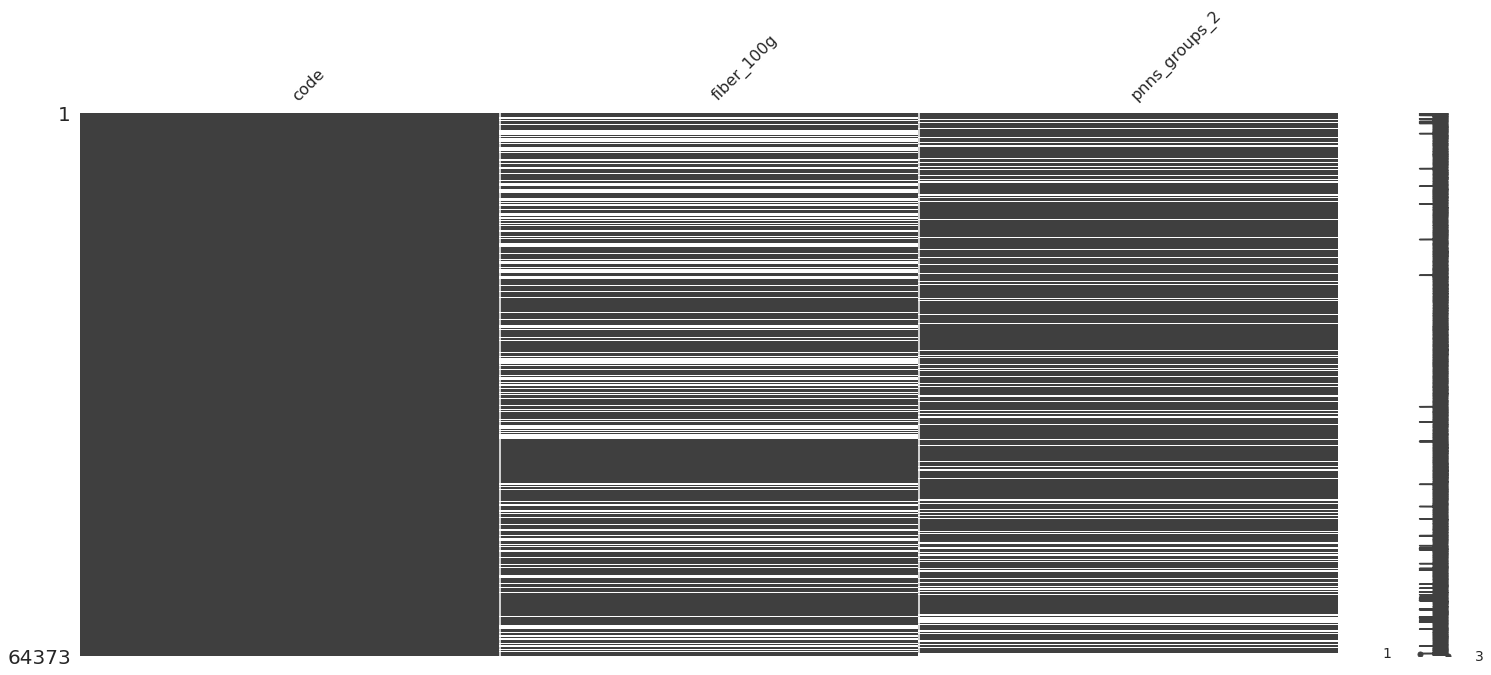

In [57]:
fiberData = appData.loc[:,["code","fiber_100g","pnns_groups_2"]]
missingValuesInfos(fiberData)

In [58]:
appData["fiber_100g"].isna().sum()

19297

<AxesSubplot:xlabel='pnns_groups_2'>

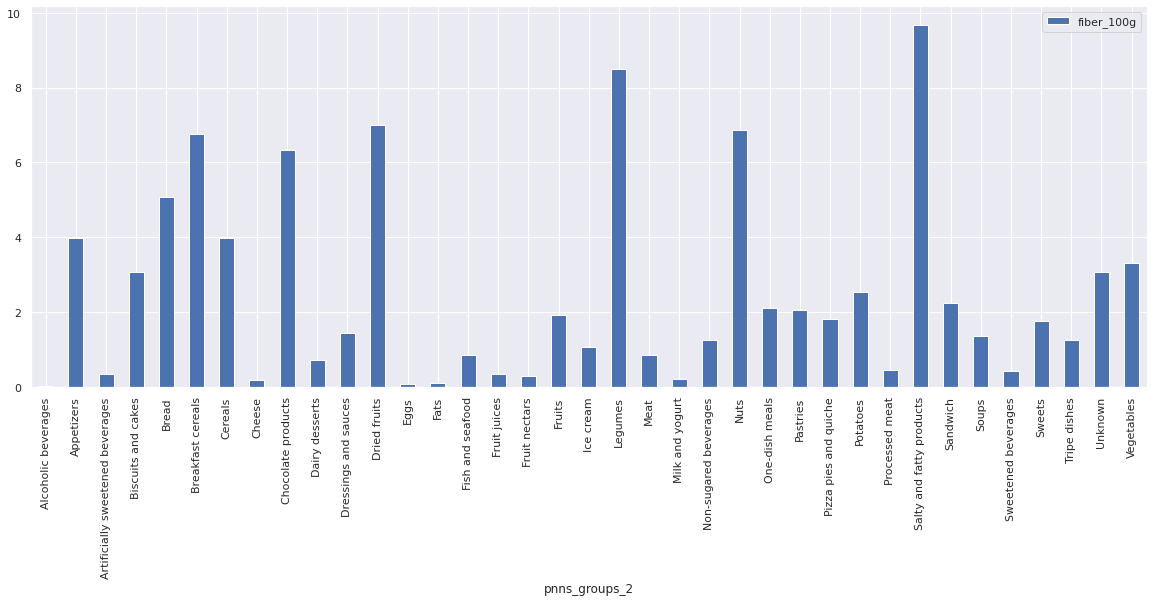

In [59]:
fiberData.groupby("pnns_groups_2").mean().plot.bar(figsize = (20,7))

Le taux de fibre dans les aliments change drastiquement d'une valeur a l'autre. on va donc imputer fiber_100g par la moyenne de chaque pnns_groups_2

In [60]:
for e in fiberData.groupby("pnns_groups_2").mean().index :
    fiberData.loc[((fiberData["pnns_groups_2"] == e) * (fiberData["fiber_100g"].isna())), "fiber_100g"] = fiberData.groupby("pnns_groups_2").mean().loc[e,"fiber_100g"]

In [61]:
fiberData.groupby("pnns_groups_2").mean().head(8)

,fiber_100g
pnns_groups_2,
Alcoholic beverages,0.024138
Appetizers,3.982627
Artificially sweetened beverages,0.340183
Biscuits and cakes,3.067979
Bread,5.079555
Breakfast cereals,6.761233
Cereals,3.985226
Cheese,0.193607


Il y a 13808 valeurs manquantes sur 193119 valeurs totales.
Le taux de remplissage est de : 92.85 %
Dimension du dataframe : (64373, 3)


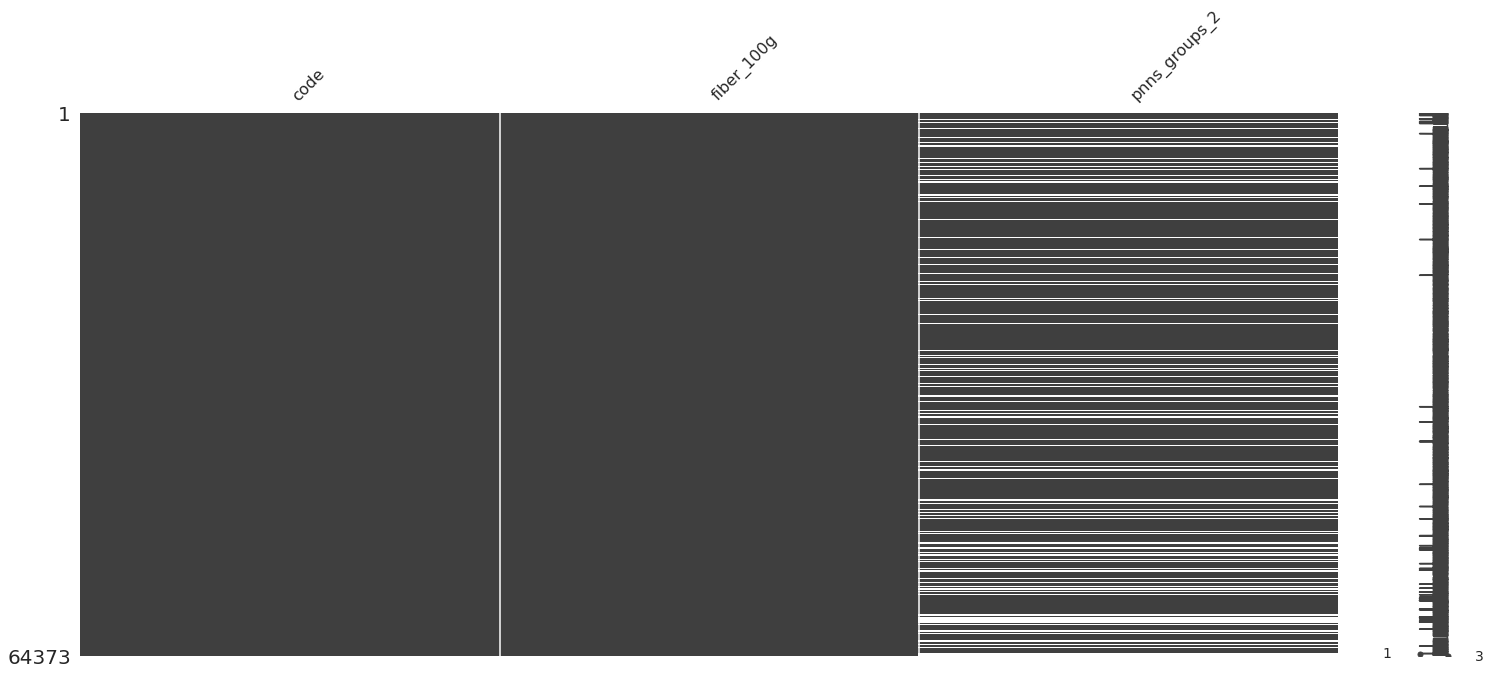

In [62]:
missingValuesInfos(fiberData)

In [63]:
appData["fiber_100g"] = fiberData["fiber_100g"]
appData.dropna(axis = 0, subset = "fiber_100g", inplace = True)

## <font color='green'>III/7 - Additives </font>

Mediane du nombre d'additifs : 1.0
Moyenne du nombre d'additifs : 2.0177214040979328
Nb de valeurs manquantes dans additives_n : 20227


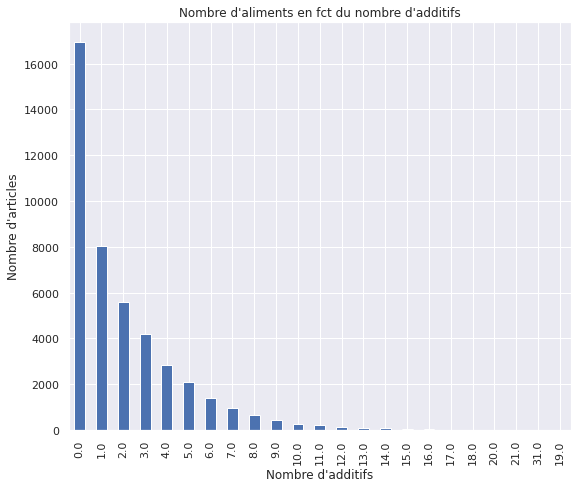

In [64]:
print("Mediane du nombre d'additifs :", appData.loc[:,"additives_n"].median())
print("Moyenne du nombre d'additifs :", appData.loc[:,"additives_n"].mean())
print("Nb de valeurs manquantes dans additives_n :", appData.loc[:,"additives_n"].isna().sum())

# Graphique barplot
appData.loc[:,"additives_n"].value_counts().plot.bar()
plt.title("Nombre d'aliments en fct du nombre d'additifs")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Nombre d'articles")
plt.show()

In [65]:
additivesData = appData.loc[:,["code","additives_n","pnns_groups_2"]].copy()

<AxesSubplot:xlabel='pnns_groups_2'>

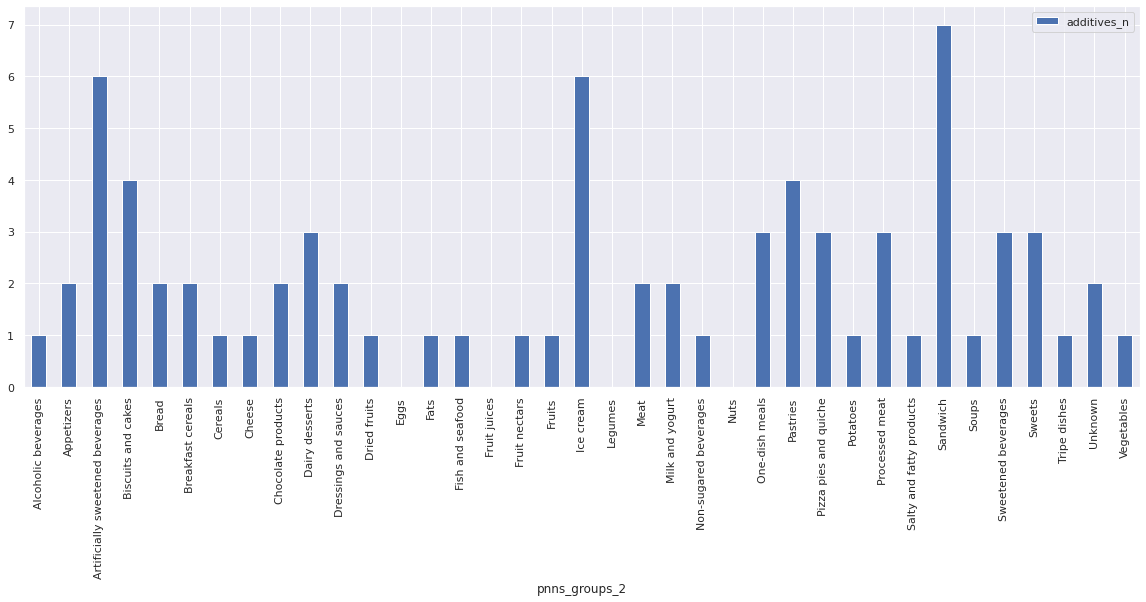

In [66]:
additivesData.groupby("pnns_groups_2").mean().round().plot.bar(figsize = (20,7))

In [67]:
for e in additivesData.groupby("pnns_groups_2").mean().index :
    additivesData.loc[((additivesData["pnns_groups_2"] == e) * (additivesData["additives_n"].isna())), "additives_n"] = additivesData.groupby("pnns_groups_2").mean().round().loc[e,"additives_n"]

Il y a 27214 valeurs manquantes sur 192894 valeurs totales.
Le taux de remplissage est de : 85.89 %
Dimension du dataframe : (64298, 3)


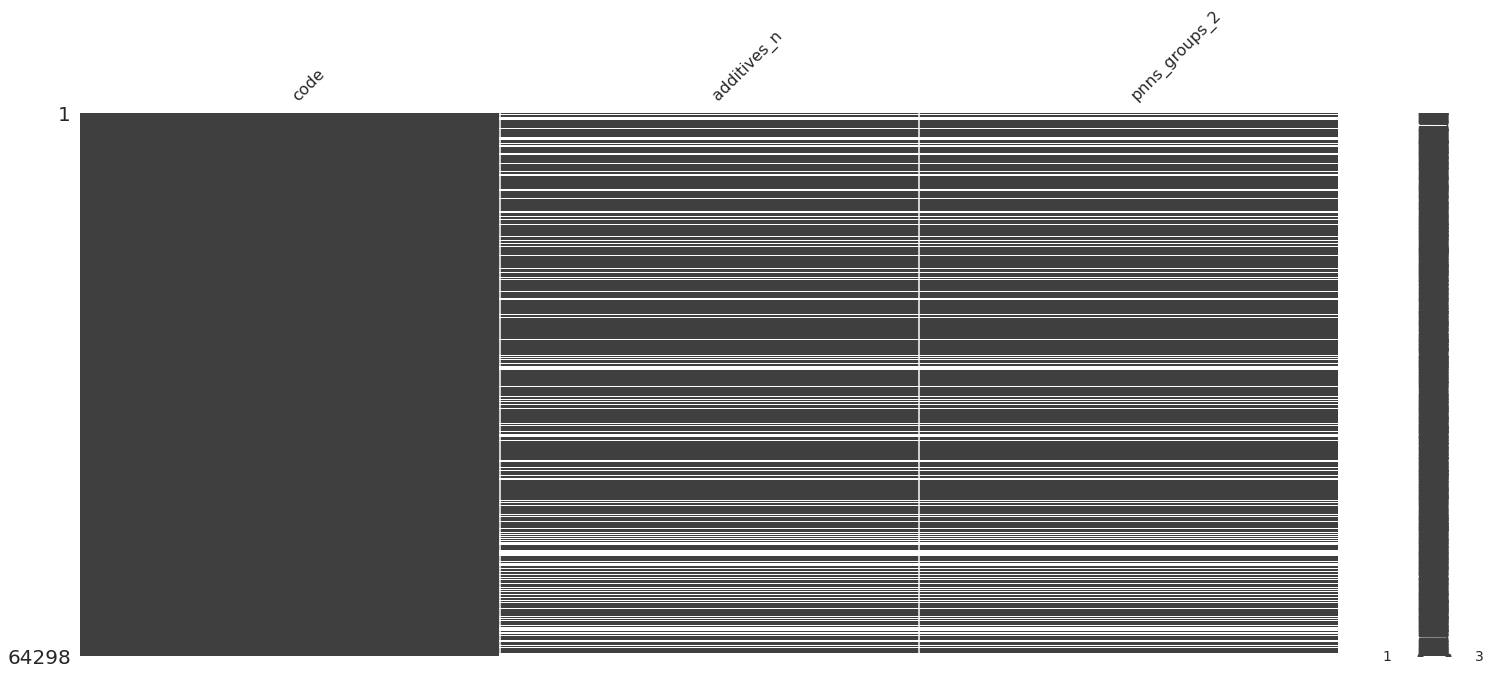

In [68]:
missingValuesInfos(additivesData)

In [69]:
appData["additives_n"] = additivesData["additives_n"]

In [70]:
appData["pnns_groups_2"].isna().sum()

13658

In [71]:
appData["additives_n"].isna().sum()

13556

Il y a 62351 valeurs manquantes sur 900172 valeurs totales.
Le taux de remplissage est de : 93.07 %
Dimension du dataframe : (64298, 14)


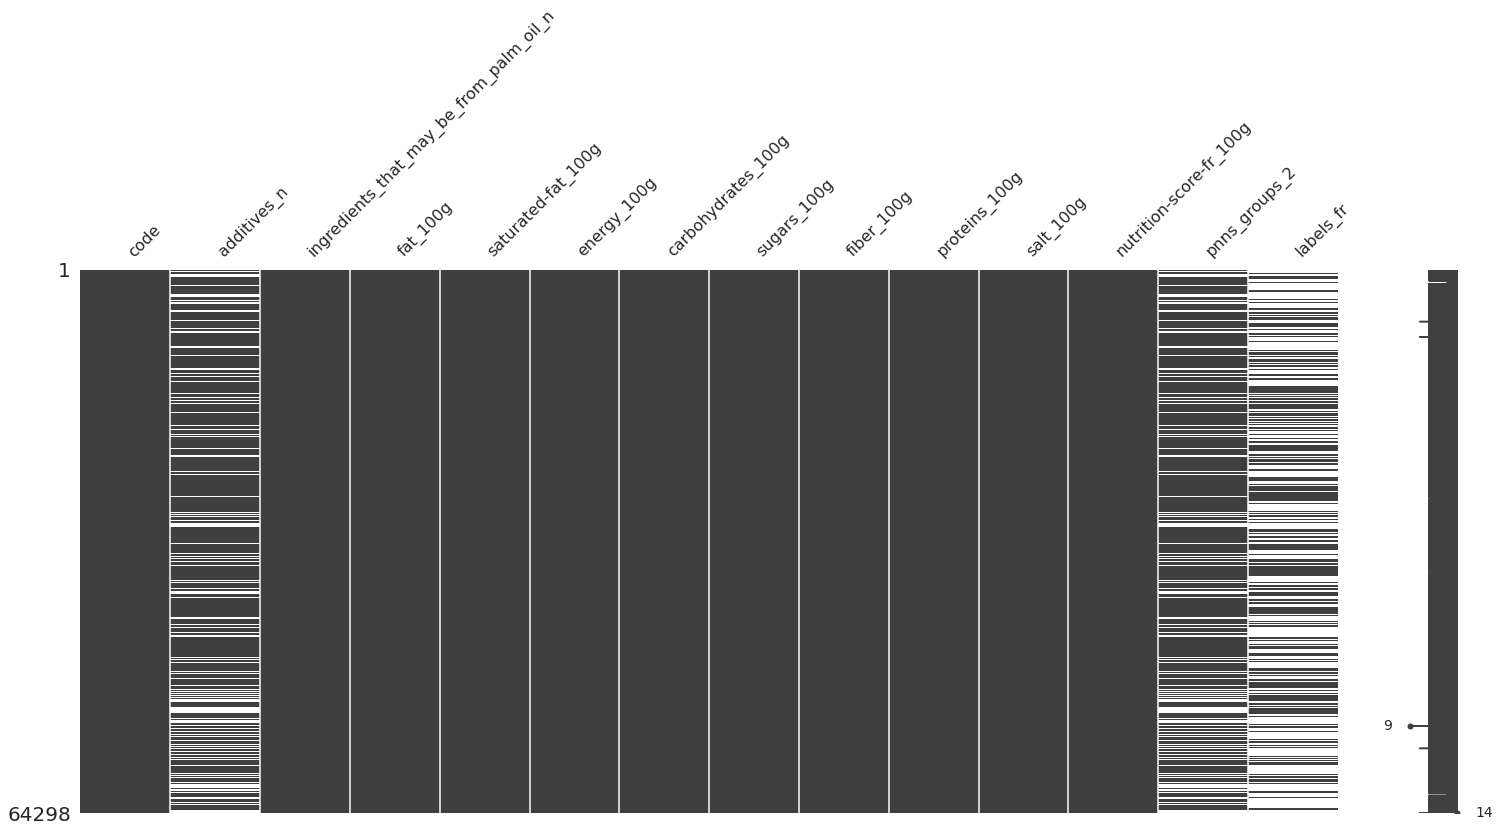

In [72]:
missingValuesInfos(appData)

In [73]:
# libération de mémoire
del additivesData
del fiberData
del imputedAppDataFat
del imputedAppDataSugars

## <font color='green'>III/8 - Filtrage post-imputation </font>

In [74]:
# Saturated-fat_100g > fat_100g
appData[appData["saturated-fat_100g"] > appData["fat_100g"]] = np.nan

# sugars_100g > carbohydrates_100g
appData[appData["sugars_100g"] > appData["carbohydrates_100g"]] = np.nan

In [75]:
appData.dropna(subset = ['fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g', 'proteins_100g','salt_100g','nutrition-score-fr_100g','additives_n','pnns_groups_2'],inplace = True)
appData.reset_index(inplace = True, drop = True)

Il y a 23798 valeurs manquantes sur 697270 valeurs totales.
Le taux de remplissage est de : 96.58 %
Dimension du dataframe : (49805, 14)


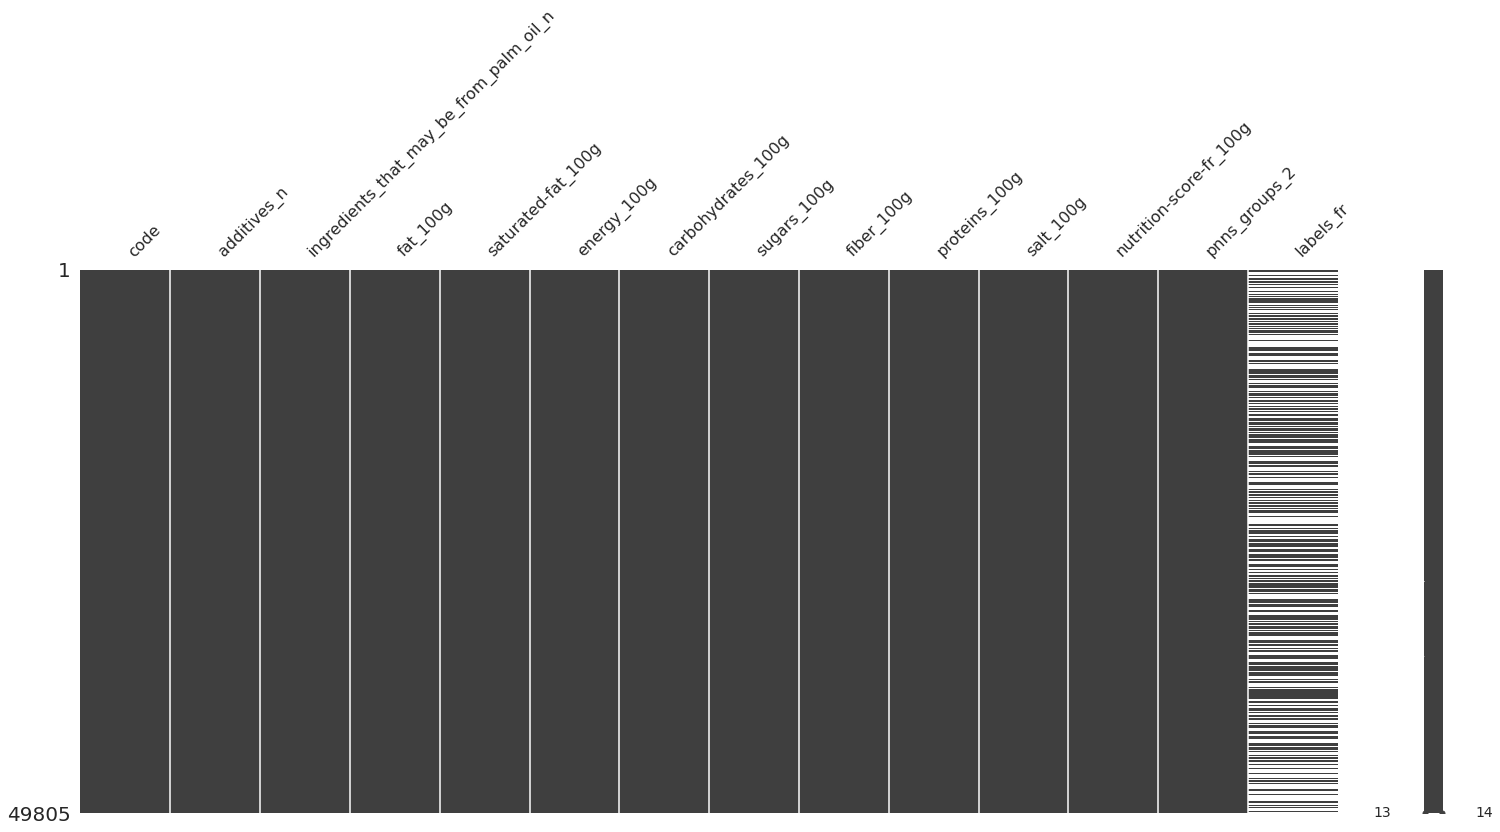

In [76]:
missingValuesInfos(appData)

## Sauvegarde

In [77]:
appData.to_csv("appData.csv", sep=',', columns = appData.columns)